# DATA SCIENCE SALARIES ANALYSIS

====================================================================
# Business Understanding

* Many people are interested in transitioning into data science roles, as it is often suggested that it is a well-paying job. However, people don't realize that while this is true, it also depends on the profile of the individuals as well as the companies they apply to.
* The goal of this analysis will be to clear up the confusion and see how salaries can vary by location, education levels, etc.

====================================================================
# Data Understanding
* The data used for this project is available on [Kaggle](https://www.kaggle.com/datasets/jackogozaly/data-science-and-stem-salaries?select=Levels_Fyi_Salary_Data.csv) under a [CC0: Public Domain License](https://creativecommons.org/publicdomain/zero/1.0/) and it was obtained by scraping data from [levels.fyi](levels.fyi)
* It contains "62,000 salary records from  top companies" and "contains useful information such as education level, compensation, race, and more".

## Import Libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# To handle missing values
from feature_engine.imputation import AddMissingIndicator, CategoricalImputer

# To handle categorical features' cardinality
from feature_engine.encoding import RareLabelEncoder

# To explore missing values
import missingno as msno

# To explore labels from categorical features
from wordcloud import WordCloud


pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 80)

## Gather the data


In [2]:
# Loading raw data 
raw_data = pd.read_csv('Levels_Fyi_Salary_Data.csv')

# Dropping cols with unclear meaning & features that were created from categorical variables (race & education)
data = raw_data.drop(['dmaid', 'rowNumber', 'cityid', 'level', 'timestamp',
                      'Race_Asian', 'Race_White', 'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic',
                     'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College'], axis=1)

# Checking data
print(data.shape)
data.head(3)

(62642, 14)


,company,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,Race,Education
0,Oracle,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000.0,20000.0,10000.0,NaN,NaN,NaN,NaN
1,eBay,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,Amazon,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000.0,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
# Keep data only regarding Data Scientists
data = data[data.title == 'Data Scientist']
data = data.drop(['title'], axis = 1)

## Exploring the data

In [4]:
data.describe()

,totalyearlycompensation,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus
count,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000
mean,203656.710628,5.059348,2.057622,138054.693561,40867.339022,17617.145074
std,109504.643967,4.103621,2.256803,64405.538993,62490.550717,22240.502215
min,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,135000.000000,2.000000,1.000000,110000.000000,0.000000,1250.000000
50%,185000.000000,4.000000,2.000000,140000.000000,20000.000000,14000.000000
75%,250000.000000,7.000000,3.000000,165000.000000,51000.000000,25000.000000
max,1000000.000000,34.000000,20.000000,700000.000000,700000.000000,350000.000000


## Assessing Data Quality

### Data Types

In [5]:
# Checking data types
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2578 entries, 419 to 62623
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company                  2578 non-null   object 
 1   totalyearlycompensation  2578 non-null   int64  
 2   location                 2578 non-null   object 
 3   yearsofexperience        2578 non-null   float64
 4   yearsatcompany           2578 non-null   float64
 5   tag                      2573 non-null   object 
 6   basesalary               2578 non-null   float64
 7   stockgrantvalue          2578 non-null   float64
 8   bonus                    2578 non-null   float64
 9   gender                   1740 non-null   object 
 10  otherdetails             1815 non-null   object 
 11  Race                     895 non-null    object 
 12  Education                1410 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 282.0+ KB


### Missing values

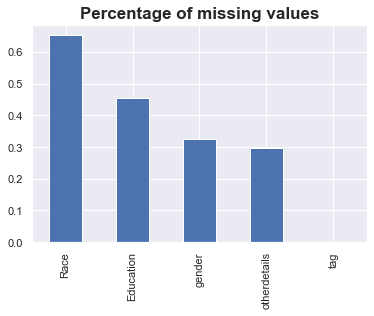

In [6]:
# Checking % of missing values      
cols_nan = [col for col in data if data[col].isna().sum() > 0]

data[cols_nan].isna().mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Percentage of missing values', weight='bold', size=17);

<AxesSubplot:>

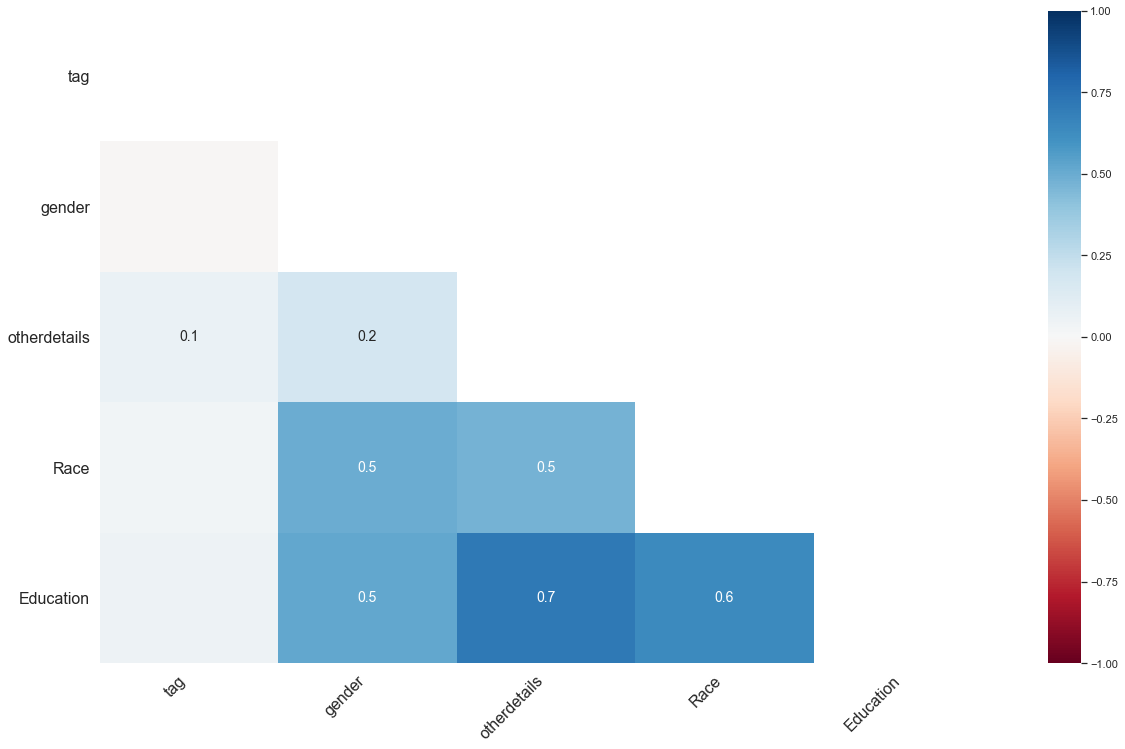

In [7]:
msno.heatmap(data)

In [8]:
data.otherdetails.value_counts()

Masters                                                                             226
Title: Data Scientist                                                               139
PhD                                                                                 100
Title: Data Scientist, Race: Asian, Academic Level: Master’s degree                  80
Race: Asian, Academic Level: Master’s degree                                         47
                                                                                   ... 
Title: Technical Lead, Race: Asian, Academic Level: Bachelor’s degree                 1
5k relocation, Academic Level: Bachelor’s degree                                      1
Title: Senior Software Developer, Race: Asian, Academic Level: Bachelor’s degree      1
Title: Data Science Manager, Race: White, Academic Level: Bachelor’s degree           1
Title: 2                                                                              1
Name: otherdetails, Length: 633,

In [9]:
data = data.drop(['otherdetails'], axis = 1)
cols_nan.remove('otherdetails')

It seems that "otherdetails" is often abstent when "Education" is missing. Moreover, by looking at the feature, we can see that contains mostly data available elsewhere (title, race, education). Thus we can remove this feature from our dataset.

====================================================================
# Data Preparation

## Handling missing values
Only categorical features seem to have missing values. Moreover, some features have a very low % of missing values while others have much more missing data.

In [10]:
# Separating cols with high / low % of missing values
THRESHOLD = 0.02

low_nan = [col for col in cols_nan if data[col].isna().mean()<THRESHOLD]
high_nan = [col for col in cols_nan if col not in low_nan]

In [11]:
low_nan

['tag']

In [12]:
high_nan

['gender', 'Race', 'Education']

### Low % of nan

In [13]:
# for columns with less than 2% of missing values we can probably drop the rows with missing values without missing too much data
data_less_nan = data.dropna(subset=low_nan)
diff = (len(data)-len(data_less_nan))/len(data)

print('Total number of obs:', data.shape[0])
print(f'Number of obs. after dropping missing values from {low_nan}:', len(data_less_nan))
print('Lost data: {0:.0%}'.format(diff))

Total number of obs: 2578
Number of obs. after dropping missing values from ['tag']: 2573
Lost data: 0%


In [14]:
data = data_less_nan.copy()

### High % of nan

In [15]:
# For missing values in the remaining features we can simply replace the missing values by "Unknown" to not bias our insights with imputation
data[high_nan] = data[high_nan].fillna('Unknown')

In [16]:
data.isna().sum()

company                    0
totalyearlycompensation    0
location                   0
yearsofexperience          0
yearsatcompany             0
tag                        0
basesalary                 0
stockgrantvalue            0
bonus                      0
gender                     0
Race                       0
Education                  0
dtype: int64

# Tags & Companies

In [17]:
data.tag = data.tag.str.capitalize()

In [18]:
# Simple unexhaustive data cleaning of "Tags"
tag_dict = {'Ml / ai':'ML/AI',
            'Ml/ai':'ML/AI',
            'Ai/ml':'ML/AI',
            'Ml':'ML',
            'Ai':'AI',
            'Ds':'Data Science',
            'Data science':'Data Science',
            'data science':'Data Science',
            'Machine Learning':'ML',
            'Machine learning': 'ML',
            'Nlp':'NLP',
            'Devops':'DevOps',
            'Aws':'AWS0',
            'Ios':'iOS',
            'Macine learning':'ML',
            'M l':'ML',
            'Ml, ai':'ML/AI',
            'Ml/ds':'ML',
            'Ml, nlp, rl':'ML/NLP',
            'Hr':'HR',
            'Qa':'QA',
            'Sap':'SAP',
            'Machine learning and ai':'ML/AI',
            'Analytics/ data science':'Data Science',
            'Ds / ml / ai':'Data Science',
            'Data scient':'Data Science',
            'Ai/nlp':'AI/NLP',
            'Ml, nlp':'ML/NLP',
            'Data science and operations research':'Data science',
            'Data science manager':'Data Science',
            'Datascientist': 'Data Science',
            'Ab testing':'A/B testing',
            'Ads & search sciences':'Advertising',
            'Ads':'Advertising',
            'Ad tech':'Advertising',
            'Algorithm':'Algorithms',
            'Analytics & cognitive':'Analytics',
            'Anlytics':'Analytics',
            'Applied econometrics':'Econometrics',
            'Applied machine learning':'ML',
            'Applied ml':'ML',
            'Applied science':'Data Science',
            'Applied scientist':'Data Science',
            'Applied scientist-ml':'ML',
            'Artificial intelligence':'AI',
            'Cloud - technical infrastructure':'CloudTech',
            'Cloud':'CloudTech',
            'Cv/ml':'ML'}
data.tag = data.tag.replace(tag_dict)

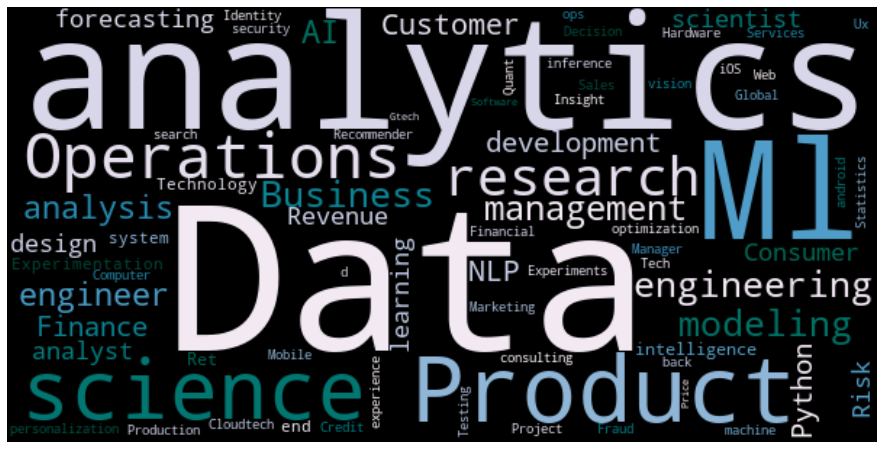

In [19]:
# Create mask (=shape of word cloud) #BuPu, Accent, GnBu, PiYG_r, PuBuGn, PuBuGn_r, Purples_r, YlGnBu_r
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

# Plot Word Cloud
allWords = ' '.join( [t for t in set(data['tag'])] )
wordCloud = WordCloud(width = 600, height = 300, random_state = 42, max_words=75, #mask=mask,
                     colormap='PuBuGn').generate(allWords)

plt.figure(figsize = (17,8))
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')

plt.show()

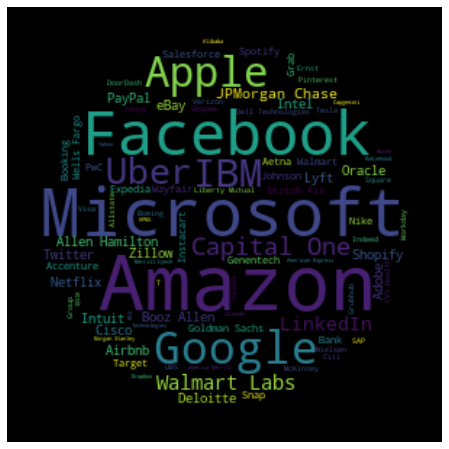

In [20]:
# Plot Word Cloud
allWords = ' '.join( [t for t in data['company']])
wordCloud = WordCloud(width = 500, height = 300, random_state = 42, max_words=150, mask=mask,
                     ).generate(allWords)

plt.figure(figsize = (17,8))
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
# plt.title('Word Cloud of Titles',  weight = 'bold', size = 15)
plt.show()

## Handling Categorical Features

### Rare Labels

In [21]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
data[cat_vars].head(3)

,company,location,tag,gender,Race,Education
419,LinkedIn,"San Francisco, CA",Data analysis,Male,Unknown,Unknown
440,Microsoft,"Seattle, WA",ML/AI,Male,Unknown,Unknown
454,Twitter,"San Francisco, CA",ML/AI,Male,Unknown,Unknown


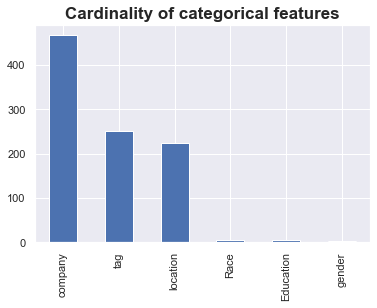

In [22]:
data[cat_vars].nunique().sort_values(ascending = False).plot(kind='bar')
plt.title('Cardinality of categorical features', weight='bold', size=17);

In [23]:
high_card = [var for var in cat_vars if data[var].nunique() > 10]

In [24]:
high_card

['company', 'location', 'tag']

In [25]:
rare_encoder = RareLabelEncoder(tol = 0.01, 
                                variables = high_card,
                                replace_with = 'Other (1%)')

data = rare_encoder.fit_transform(data)

# Data Exploration

### Total Compensation & Categorical features

In [26]:
colors = ['#1780a1', '#065a60', '#a01a58']

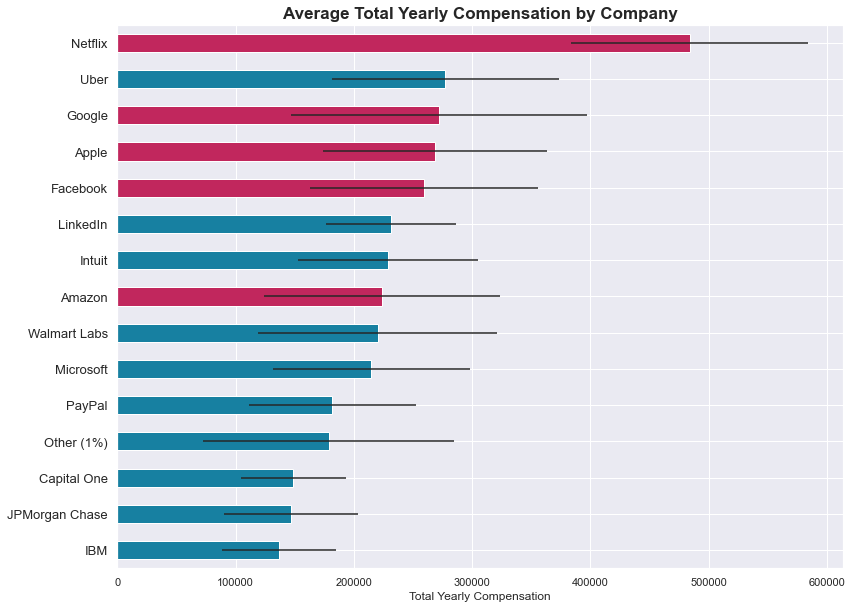

In [27]:
tmp = data.groupby('company')['totalyearlycompensation'].agg(['mean', 'std'])
tmp = tmp.sort_values(by='mean')

# plot into a bar graph
FAANG = ['Facebook', 'Amazon', 'Apple', 'Netflix', 'Google']
colors = ['#C1275D' if comp in FAANG else '#1780a1' for comp in tmp.index]
tmp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title="Price", color=colors, figsize=(13,10))

plt.title('Average Total Yearly Compensation by Company', weight='bold', size=17)
plt.xlabel('Total Yearly Compensation')
plt.yticks(size=13)
plt.ylabel('')
plt.show() 

In [28]:
for loc in data.location:
    if 'CA' in loc:
        print(loc)

San Francisco, CA
San Francisco, CA
San Francisco, CA
San Francisco, CA
Mountain View, CA
San Francisco, CA
Menlo Park, CA
Cupertino, CA
Sunnyvale, CA
San Jose, CA
Mountain View, CA
Mountain View, CA
Cupertino, CA
San Francisco, CA
San Francisco, CA
San Francisco, CA
Cupertino, CA
San Francisco, CA
Mountain View, CA
San Jose, CA
San Francisco, CA
San Francisco, CA
Sunnyvale, CA
Menlo Park, CA
San Francisco, CA
Sunnyvale, CA
Menlo Park, CA
San Francisco, CA
Menlo Park, CA
San Francisco, CA
San Francisco, CA
San Francisco, CA
San Francisco, CA
Mountain View, CA
Mountain View, CA
San Jose, CA
San Francisco, CA
Cupertino, CA
Los Angeles, CA
San Francisco, CA
Menlo Park, CA
San Francisco, CA
Sunnyvale, CA
Mountain View, CA
San Francisco, CA
San Francisco, CA
Mountain View, CA
Mountain View, CA
San Francisco, CA
San Francisco, CA
San Jose, CA
San Francisco, CA
San Jose, CA
San Francisco, CA
San Francisco, CA
Cupertino, CA
San Jose, CA
San Francisco, CA
San Francisco, CA
Mountain View, CA
San

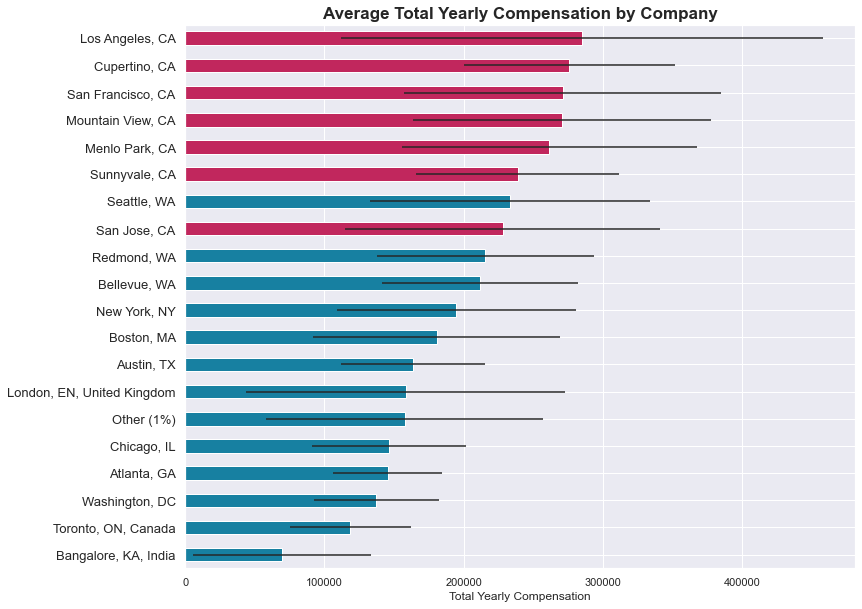

In [29]:
tmp = data.groupby('location')['totalyearlycompensation'].agg(['mean', 'std'])
tmp = tmp.sort_values(by='mean')

# plot into a bar graph
colors = ['#C1275D' if 'CA' in loc else '#1780a1' for loc in tmp.index]
tmp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title="Price", color=colors, figsize=(12,10))

plt.title('Average Total Yearly Compensation by Company', weight='bold', size=17)
plt.xlabel('Total Yearly Compensation')
plt.yticks(size=13)
plt.ylabel('')
plt.show() 

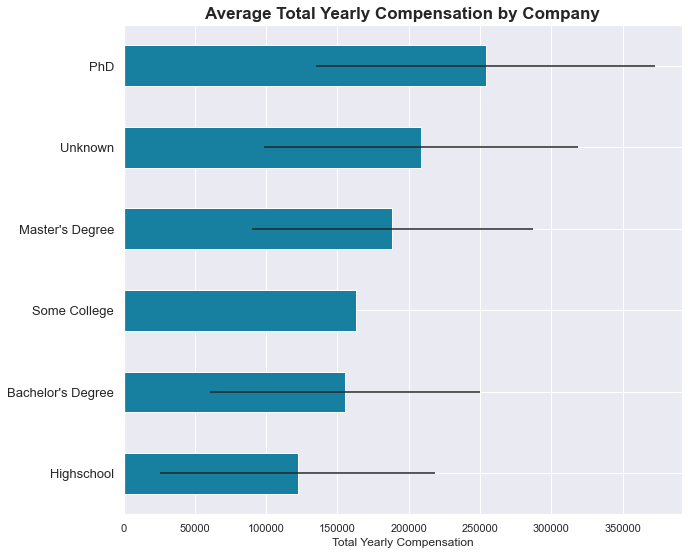

In [30]:
tmp = data.groupby('Education')['totalyearlycompensation'].agg(['mean', 'std'])
tmp = tmp.sort_values(by='mean')

# plot into a bar graph
tmp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title="Price", color='#1780a1', figsize=(10,9))

plt.title('Average Total Yearly Compensation by Company', weight='bold', size=17)
plt.xlabel('Total Yearly Compensation')
plt.yticks(size=13)
plt.ylabel('')
plt.show() 

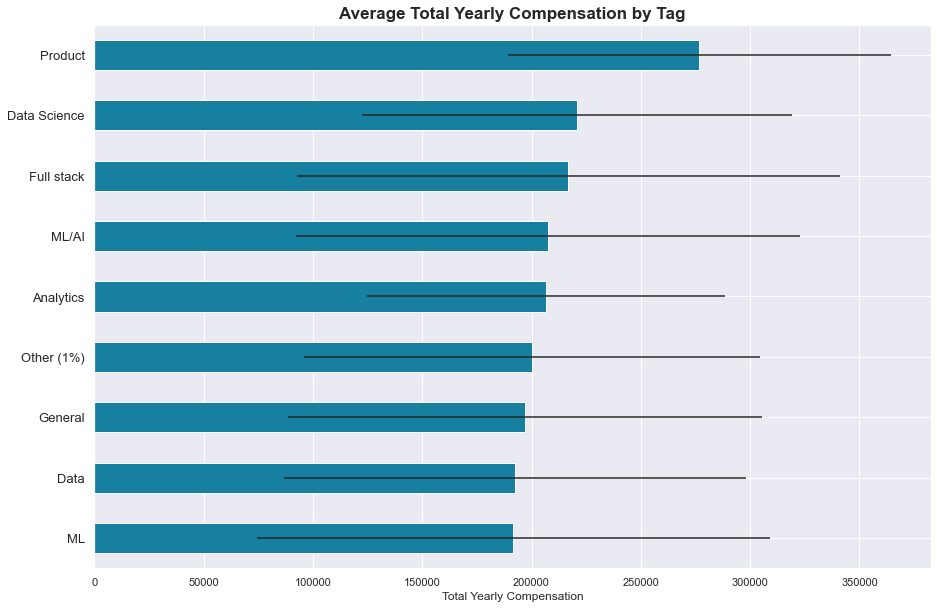

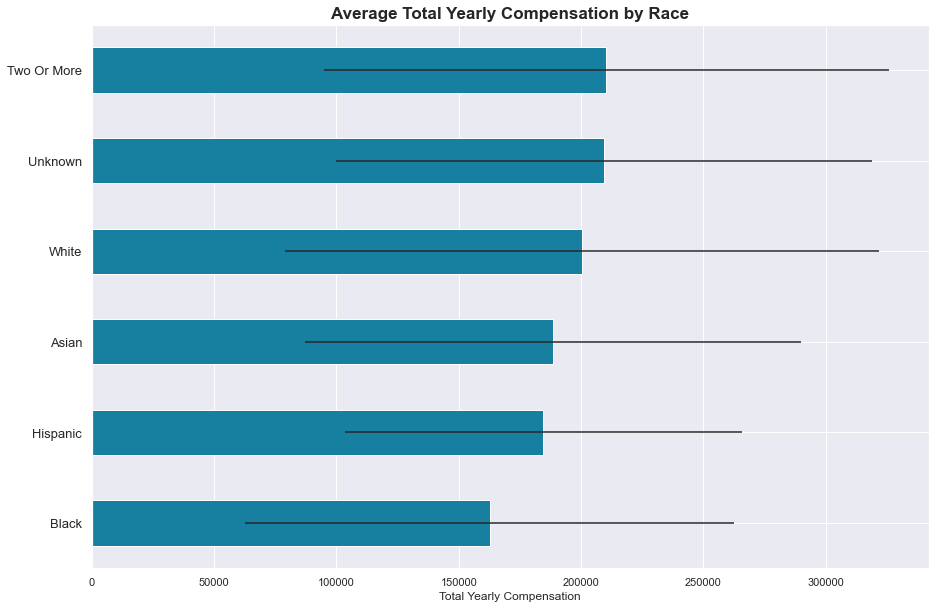

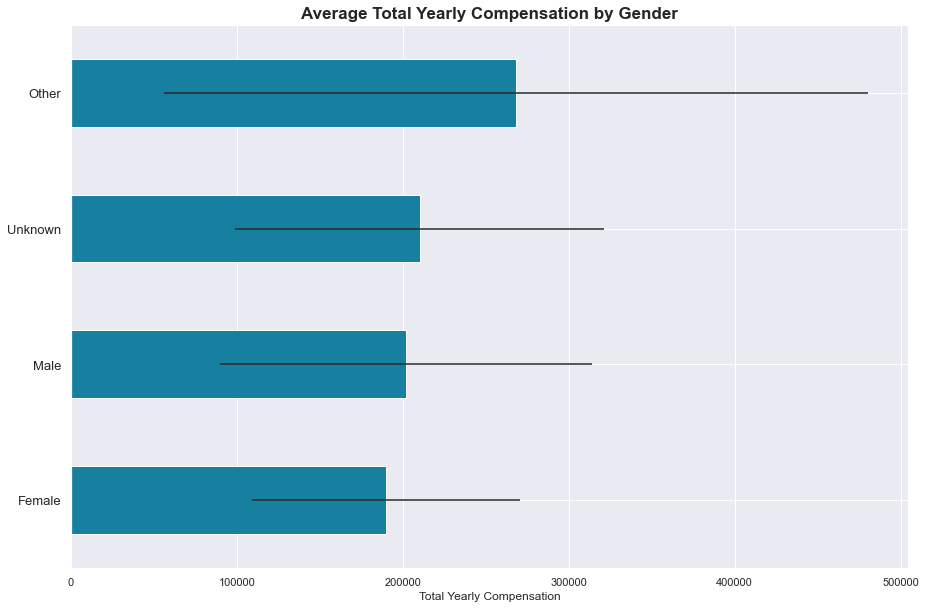

In [31]:
for var in ['tag', 'Race', 'gender']:
    # get mean & std compensation for each categorical variable
    tmp = data.groupby(var)['totalyearlycompensation'].agg(['mean', 'std'])

    # plot into a bar graph
    tmp.sort_values(by='mean').plot(kind="barh", y="mean", legend=False,
                 xerr="std", title="Price", color=colors, figsize=(15,10))
    
    plt.title(f'Average Total Yearly Compensation by {var.capitalize()}', weight='bold', size=17)
    plt.xlabel('Total Yearly Compensation')
    plt.yticks(size=13)
    plt.ylabel('')
    plt.show() 

### Experience & Total Salary

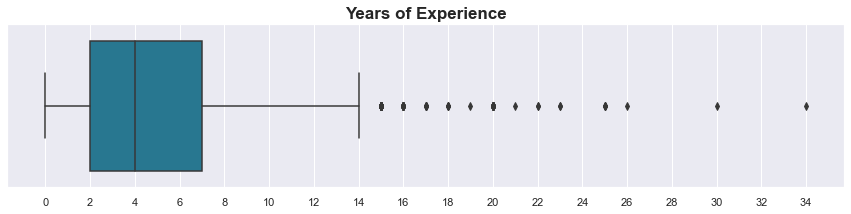

In [32]:
plt.figure(figsize=(15,3))
sns.boxplot(x=data.yearsofexperience, color=colors[0])
plt.title('Years of Experience', weight='bold', size=17)
plt.xlabel('')
plt.xticks(np.arange(0,35,2))
plt.show()

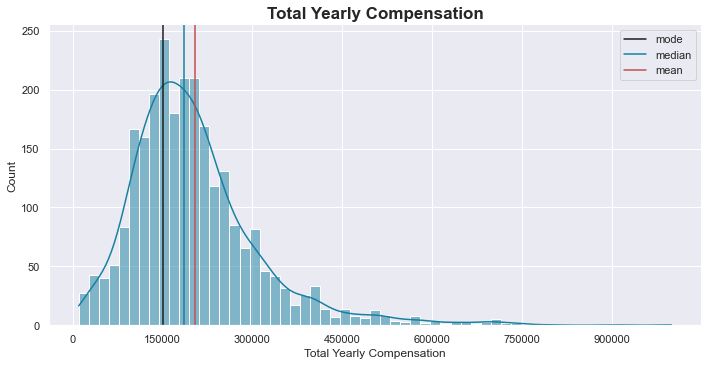

In [33]:
tot_salary = data.totalyearlycompensation
median = tot_salary.median()
mean = tot_salary.mean()
mode = tot_salary.mode()[0]

sns.displot(kde=True, data=tot_salary, color=colors[0], aspect=2, height=5)

plt.axvline(x=mode, ymin=0, ymax=2500, color='k', label='mode')
plt.axvline(x=median, ymin=0, ymax=2500, color=colors[4], label='median')
plt.axvline(x=mean, ymin=0, ymax=2500, color='r', label='mean')

plt.title('Total Yearly Compensation', weight='bold', size=17)
plt.xticks(np.arange(0,max(tot_salary),150000))
plt.xlabel('Total Yearly Compensation')

plt.legend()
plt.show()

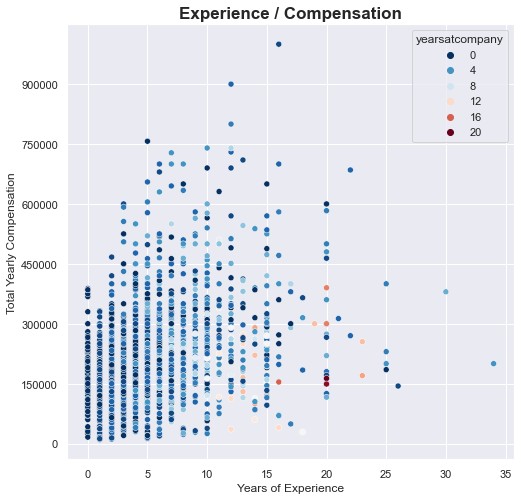

In [34]:
plt.figure(figsize=(8,8)) 
sns.scatterplot(x=data.yearsofexperience, y=data.totalyearlycompensation, hue=data.yearsatcompany, palette='RdBu_r')
plt.title('Experience / Compensation', weight='bold', size=17)
plt.yticks(np.arange(0,max(tot_salary),150000))
plt.ylabel('Total Yearly Compensation')
plt.xlabel('Years of Experience')
plt.show()

In [35]:
# Correlation between Experience & Compensation
data.yearsofexperience.corr(data.totalyearlycompensation)

0.35355827365194525

In [36]:
# Correlation between Years at Company & Compensation
data.yearsatcompany.corr(data.totalyearlycompensation)

0.10651803862942469

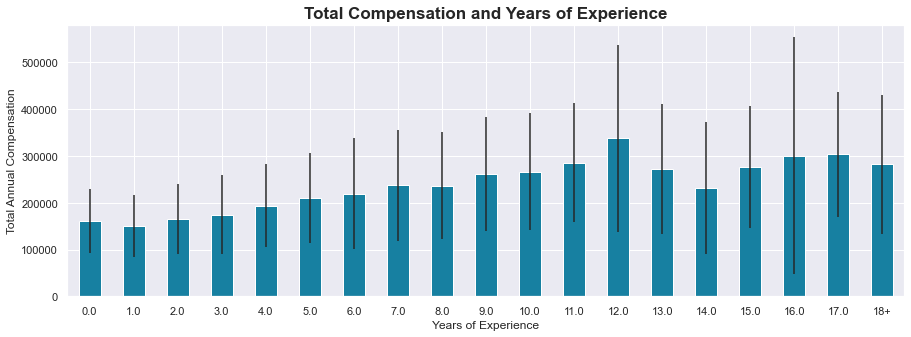

In [37]:
# Getting the data
tmp = data.copy()
tmp.yearsofexperience = [y if y < 18 else '18+' for y in data.yearsofexperience ]
tmp = tmp.groupby('yearsofexperience').agg(['mean','std'])['totalyearlycompensation']

# Plotting
tmp.plot(kind='bar', yerr='std', figsize=(15,5), color=colors[0], legend=False)
plt.title('Total Compensation and Years of Experience', weight='bold', size=17)
plt.ylabel('Total Annual Compensation')
plt.xlabel('Years of Experience')
plt.xticks(rotation=0)
plt.show()
